# **AUTOKODERY SPLOTOWE**

# **IMPORT ODPOWIEDNICH BIBLIOTEK**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# **WCZYTANIE ZBIORU DANYCH**

In [ ]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()

Podział danych na zestawy treningowy i walidacyjny.  Zbiór Fashion MNIST jest podzielony na zbiór uczący i testowy, natomiast wyodrębnimy 5000 obrazów ze zbioru treningowego do walidacji.

In [ ]:
# Podział na dane walidacyjne i treningowe
X_train, X_val = X_train[:-5000], X_train[-5000:]

# **DATA PREPROCESSING**

**Normalizacja** odcienia pikseli do zakresu [0,1].

In [ ]:
X_train = X_train.astype("float32") / 255.
X_val = X_val.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

# **TWORZENIE MODELU**

Autokoder składa się z dwóch części: kodera i dekodera. Obydwa są modelami Sequential. Autokoder jest modelem Sequential, w którym po koderze występuje dekoder.

Koder - ma na celu "skompresowanie" obrazu wejściowego (w tym przypadku o rozmiarze 28x28 pikseli) do mniejszej przestrzeni reprezentacji o niższej wymiarowości. Składa się z następujących warstw:
*   Pierwsza warstwa przekształca dane wejściowe (obraz) w odpowiedni kształt, który jest zgodny z wymaganiami sieci konwolucyjnej.
*   Pierwsza warstwa konwolucyjna z 16 filtrami, które wykonują operację konwolucji z rozmiarem filtra 3x3. Padding "same", funkcja aktywacji to ReLU.
*   Pierwsza warstwa max poolingu, która zmniejsza wymiary obrazu o połowę.
*   Druga warstwa konwolucyjna, która podobnie jak pierwsza wykonuje operację konwolucji, ale teraz z 32 filtrami.
*   Ponowna operacja max poolingu zmniejsza wymiar obrazu o połowę.
*   Trzecia warstwa konwolucyjna z 64 filtrami. Ponownie wykonuje konwolucję i aktywację ReLU.
*   Kolejna operacja max poolingu.
*   Ostatnia warstwa konwolucyjna w enkoderze. Liczba filtrów wynosi 30, co daje bardziej abstrakcyjną reprezentację wejściowego obrazu.
*  **GlobalAvgPool2D()** - warstwa globalnego uśredniania, która zmienia przestrzenny rozmiar obrazu do pojedynczej liczby przez obliczenie średniej wartości w każdym kanale. Wynikiem tej warstwy jest wektor o rozmiarze 30 (liczba kanałów).

In [ ]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28,28,1]),
    tf.keras.layers.Conv2D(16, 3, padding = "same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, padding = "same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, 3, padding = "same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(30, 3, padding = "same", activation='relu'),
    tf.keras.layers.GlobalAvgPool2D()
])

Dekoder - ma za zadanie odtworzenie obrazu na podstawie skompresowanej reprezentacji uzyskanej przez enkoder.
*   Warstwa gęsta 3x3x16.
*   Warstwa przekształcająca dane z powrotem do postaci obrazu o wymiarach 3x3 i 16 kanałach.
*   Warstwa transponowanej konwolucji. Zwiększa wymiary obrazu o współczynnik 2 i stosuje 32 filtry, funkcja aktywacji to ReLU.
*   Warstwa transponowanej konwolucji. Zwiększa wymiary obrazu o współczynnik 2 i stosuje 16 filtry, funkcja aktywacji to ReLU, padding "same".
*   Ostatnia warstwa transponowanej konwolucji, która generuje obraz o jednym kanale (np. w odcieniach szarości) i wielkości 28x28,  padding "same"
*   Na końcu obrazu przywracany jest ostateczny kształt 28x28. Rekonstruowany obraz ma taki sam rozmiar jak oryginalny obraz wejściowy.

In [ ]:
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation='relu'),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding = "same"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding = "same"),
    tf.keras.layers.Reshape([28,28])
])

In [ ]:
encoder.build(input_shape=(None, 28, 28, 1))

In [ ]:
autoencoder = models.Sequential([encoder, decoder])

# **KOMPILOWANIE MODELU**

Jako optmalizator należy zastostosować nadam. Funkcją kosztu jest MSE.

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

# **TRENING AUTOKODERA**

Należy wywołać metodę fit(). X_train zostaje użyte jako dane wejściowe i dane docelowe. Liczba epok jest równa 50. Przebieg walidacyjny.

In [ ]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, X_val)
)

Epoch 1/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 64s 141ms/step - loss: 0.0765 - val_loss: 0.0286
Epoch 2/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 77s 132ms/step - loss: 0.0264 - val_loss: 0.0229
Epoch 3/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 83s 134ms/step - loss: 0.0220 - val_loss: 0.0210
Epoch 4/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - loss: 0.0200 - val_loss: 0.0190
Epoch 5/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - loss: 0.0186 - val_loss: 0.0181
Epoch 6/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 7/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 62s 143ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 8/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 77s 132ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 9/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 82s 133ms/step - loss: 0.0159 - val_loss: 0.0157
Epoch 10/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 85s 139ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 11/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - loss: 0.0151 - val_loss: 0.0152
Epoch 12/50
430/430

# **WIZUALIZOWANIE REKONSTRUKCJI**

Należy porównać dane wejściowe z wyjściowymi, w tym celu trzeba wyświetlić kilka obrazów z zestawu walidacyjnego wraz z ich rekonstrukcjami.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


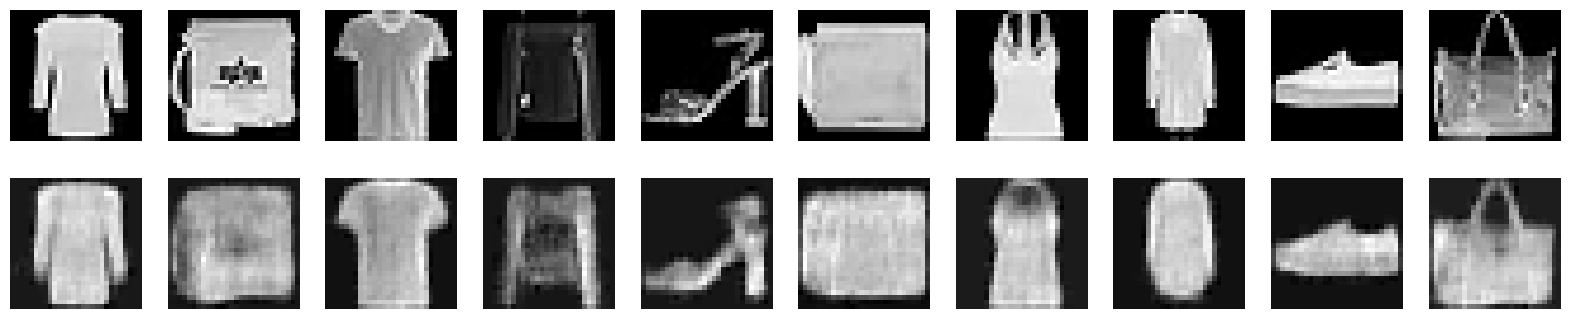

In [ ]:
def visualize_reconstruction(autoencoder, data, num_images=10):
    reconstructed = autoencoder.predict(data[:num_images])

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Oryginalny obraz
        plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Rekonstrukcja
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.show()

# Wizualizacja wyników
visualize_reconstruction(autoencoder, X_val)